# TP 2 : Computer Vision

## Part 1 : segmentation

In this part of the TP, we are going to implement two approaches to image segmentation :

- algorithm of Otsu (histogram-based segmentation)
- a simple region-growing based algorithm

First, let us load some packages and define some helper functions (as in the previous TP)

(800, 586)

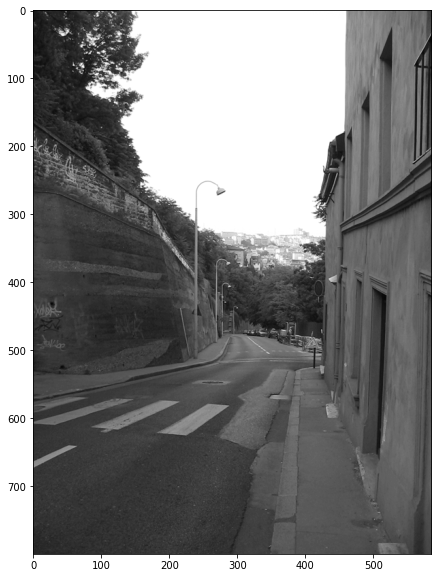

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio.v2 as imageio
from skimage import color

is_colab = False

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

file_dir = 'images/'
file_name = 'crossing'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/crossing.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

## Otsu's algorithm

Otsu's method is based on finding a threshold to split the image into two separate segments, based simply on their grey-level values. Since the maximum number of grey-levels is finite (and small: 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the following criterion :

$argmin_{\tau} \: \omega_0(\tau)\sigma_0(\tau) + \omega_1(\tau)\sigma_1(t)$

where

- $\sigma_0(\tau)$ and $\sigma_1(\tau)$ are the variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are weights of the first and second regions

and 

- $\omega_0(\tau) = \sum_{p \in \Omega} \mathbb{1}_{\tau}(I(p)), \qquad$
- $\omega_1(\tau) = \sum_{p \in \Omega} 1-\mathbb{1}_{\tau}(I(p))$

and 

$\mathbb{1}_{\tau}(I(p)) =\begin{cases}
        1 \; \text{if} \: I(p)<=\tau\\
        0 \; \text{otherwise}
\end{cases}$

Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions. Furthemore, remember that the image is normalised between 0 and 1, with 256 discrete values. Choose the threshold values accordingly.

In [2]:
def var(weights, values):
    return (values*values*weights/weights.sum()).sum() - ((values * weights/weights.sum()).sum()) ** 2

In [3]:
def segmentation_otsu(img):
    taus = np.linspace(0,255,256).astype(int)
    # print(len(taus))
    # TO FILL IN
    hist_vals, hist_bins = np.histogram(img.flatten(), bins=np.linspace(0,1,257))
    hist_bins = hist_bins[:-1]
    # plt.plot(hist_vals)
    # print(type(hist_vals))
    # print(len(hist_vals),len(hist_bins))
    # print(hist_bins*256)
    scores = []
    for tau in taus:
        vals_0 = hist_vals[0:tau+1]
        bins_0 = hist_bins[0:tau+1]
        vals_1 = hist_vals[tau+1:]
        bins_1 = hist_bins[tau+1:]
        score = vals_0.sum() * var(vals_0, bins_0) + vals_1.sum() * var(vals_1, bins_1)
        scores.append(score)
    min_score = np.nanmin(scores)
    # print(scores)
    tau_out = np.nanargmin(scores)
    threshold = tau_out/256
    img_out = img.copy()
    img_out[img < threshold] = 0
    img_out[img >= threshold] = 1
    # RETURN BOTH THE SEGMENTED IMAGE AND THE THRESHOLD WHICH YOU HAVE FOUND
    return img_out,tau_out

In [4]:
segmentation_otsu(img_gray)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 163)

Carry out the segmentation on the input image and display the result

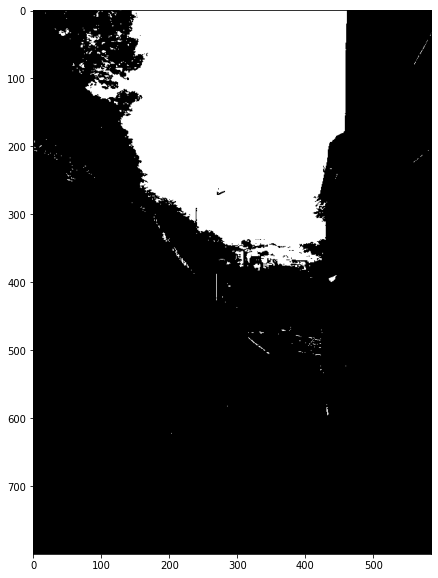

In [5]:
img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

In [6]:
tau

163

__Question 1.1__ What problem can you see with the segmentation result ? What technique(s) (seen in the lesson) could you use to clean the result up ? 

__Answer__: there are some tiny black/white pixel remains in the big white or black blob, we could use the mathematical morphology.

Carry this out on the output image, and imwrite the result. You can find the necessary function(s) in the following package :

skimage.morphology

Choose the neighbourhood parameter of the functions to obtain the best results.

In [7]:
import skimage.morphology as mp

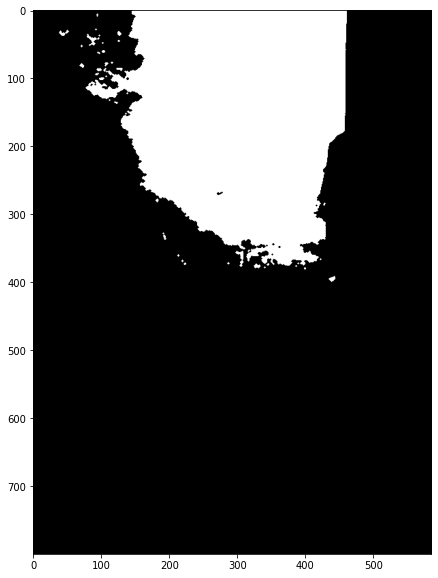

In [8]:
display_image((mp.binary_closing(mp.binary_opening(img_out_otsu))))

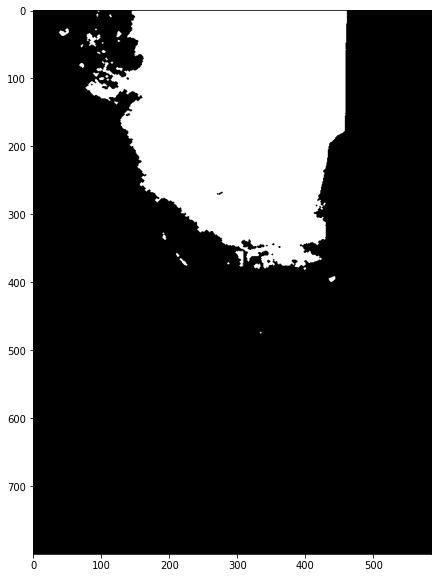

In [9]:
display_image(mp.binary_opening(mp.binary_closing(img_out_otsu)))

__Question 1.2__ In which order did you carry out the operations (you can test the different possibilities) ? Explain why you think this order is best.

__Answer__ First opening then closing is better. Since in this image, there are more white spots that needs to be eliminated, so first remove them (by opening) is better.

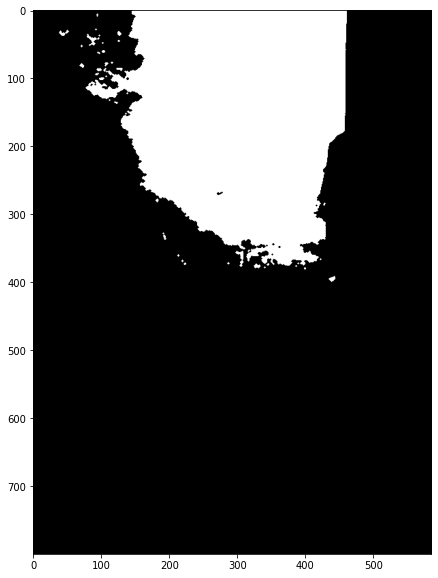

In [10]:
# FILL IN HERE
img_out_otsu_cleaned = mp.binary_closing(mp.binary_opening(img_out_otsu)) # FILL IN HERE

display_image(img_out_otsu_cleaned)
write_image(img_out_otsu_cleaned,file_name+'_segmentation_otsu_cleaned_1.png')

Let's change the image, and carry out the segmentation again.

/tmp/ipykernel_174/717612808.py:2: RuntimeWarning: invalid value encountered in divide
  return (values*values*weights/weights.sum()).sum() - ((values * weights/weights.sum()).sum()) ** 2


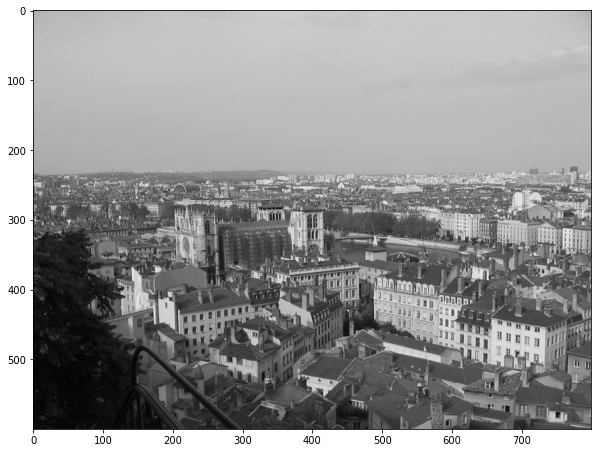

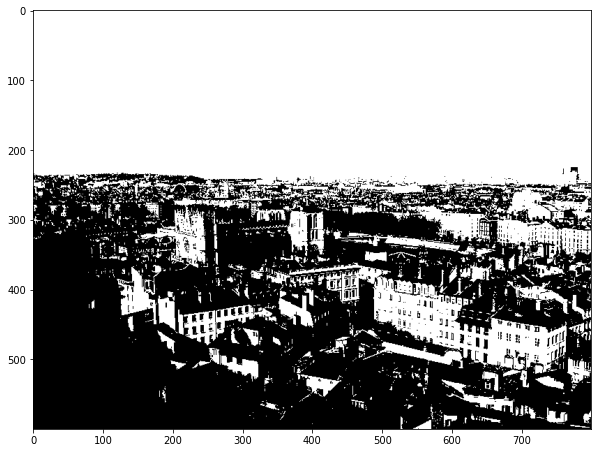

In [11]:
file_name = 'town'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/town.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

In [12]:
tau

126

As we can see, there is no notion of connectivity in the algorithm of Otsu (two regions far away can be in the same segment). For such a notion, we turn to region merging.

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add pixels progressively to the region, according to a criterion. We choose the following criterion :

- $I(p)$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

In [15]:
from scipy.ndimage.morphology import distance_transform_edt

In [33]:
def initialize_segmentation(seed_pt,img_shape):
    seg_init = np.ones(img_shape)
    seg_init[seed_pt[0], seed_pt[1]] = 0
    dis = distance_transform_edt(seg_init)
    seg_init[dis <= 1] = 0
    return seg_init

Now, create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

You will have to choose a neighbourhood that indicates which neighbouring pixels we want to try and include in the region. Use the following neighbourhood: $$ \begin{pmatrix} 0 & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 0\end{pmatrix}$$

In [27]:
a = np.asarray([10,2,3])
for i in a[a<=3]:
    print(i)
b = np.asarray([1,4,9])

2
3


In [29]:
b[a<=3] = [1,2]

In [30]:
b

array([1, 1, 2])

In [90]:
def segmentation_region_growing(img,seed_pt,tau):

    # FILL IN HERE
    seg_init = initialize_segmentation(seed_pt, img.shape)
    seg_n = seg_init.copy()
    # seg mask * image is the result
    region = img[seg_n == 0]
    region_avg = region.mean()
    dis = distance_transform_edt(seg_n)
    # neighbors = img[dis==1]
    # print(neighbors)
    # print(seg_init)
    # seg_n[np.where(((dis == 1).nonzero()) & (abs(img - region_avg) <= tau))] = 0
    # print(seg_n)
    is_expanding = False
    max_loop = float('inf')
    i = 0
    while (i<max_loop):
        seg_n_old = seg_n.copy()
        for ind_x, ind_y in zip((dis == 1).nonzero()[0],(dis==1).nonzero()[1]):
            pixel = img[ind_x, ind_y]
            if abs(pixel - region_avg) <= tau:
                seg_n[ind_x, ind_y] = 0
        if (seg_n == seg_n_old).all(): # if no progress, end
            break
        region = img[seg_n == 0]
        region_avg = region.mean()
        dis = distance_transform_edt(seg_n)
        i += 1
    # RETURN BOTH THE SEGMENTED IMAGE AND THE INITIALISATION WHICH YOU FOUND
    # reverse the mask to fit the actuall blackness/whiteness
    # seg_n = 1- seg_n
    return seg_n, seg_init
    return seg_n,seg_init

Carry out the segmentation on the input image with the seed point and threshold specified in the following code :

In [91]:
seed_pt = np.asarray([130,350])
tau = 20.0 * (1.0/256.0)
img_out_region_growing,seg_init = segmentation_region_growing(img_gray,seed_pt,tau)

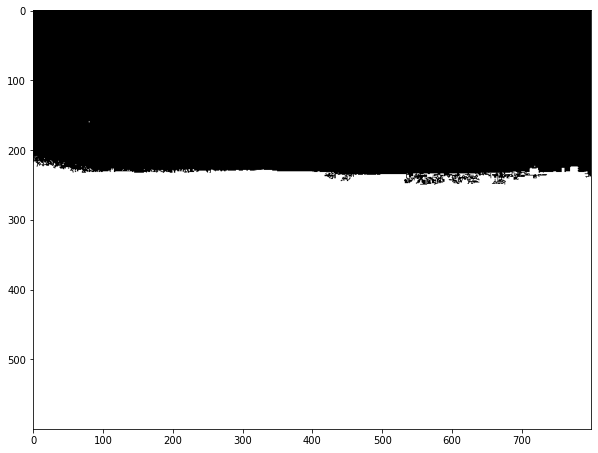

In [92]:
display_image(img_out_region_growing)

In [85]:
write_image(seg_init,file_name+'_segmentation_region_growing_init.png')
write_image(img_out_region_growing,file_name+'_segmentation_region_growing.png')

__Question 1.3__ What final problem, especially concerning the boundary between the regions, can you see ? What method could be used instead of region growing, could solve this problem ?

__Answer__ the boundary is not very smooth and not robust to outliers. we can use for example active contours to tackle it.

In [105]:
from skimage.segmentation import active_contour
from skimage.filters import gaussian

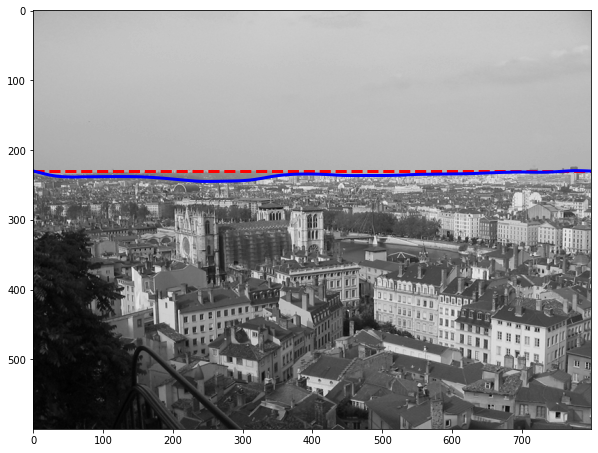

In [107]:
x = np.linspace(230, 230, 100)
y = np.linspace(0, img_gray.shape[1]-1, 100)
init = np.array([x, y]).T
snake = active_contour(gaussian(img_gray, 1, preserve_range=False),
                       init, boundary_condition='fixed',
                       alpha=0.1, beta=1.0, w_line=-5, w_edge=0, gamma=0.1)
display_image(img_gray)
plt.plot(init[:, 1], init[:, 0], '--r', lw=3)
plt.plot(snake[:, 1], snake[:, 0], '-b', lw=3)